Let's first initialize the matrices and some variables

In [5]:
from generate_sparse_matrix import generate_sparse_matrix
from accesses_calculation import input_accesses_calculation
from accesses_calculation import output_accesses_calculation
from bandwidth_calculation import input_bandwidth_calculation
from bandwidth_calculation import output_bandwidth_calculation
from avg_reuse_distance import avg_reuse_distance
import math
import matplotlib.pyplot as plt
import numpy as np

# Matrix generation
In_data_size = 8  # has to be a multiple of 8 such that the memory locations are not segmented
Out_data_size = 24  # has to be a multiple of 8 such that the memory locations are not segmented

X_rows, X_columns, X_sparsity = 4, 4, 0.1  # X_columns = Y_rows
Y_rows, Y_columns, Y_sparsity = 4, 4, 0.1

X_elem_size, Y_elem_size = 2, 2

X = generate_sparse_matrix(X_rows, X_columns, X_sparsity, In_data_size)
Y = generate_sparse_matrix(Y_rows, Y_columns, Y_sparsity, In_data_size)
Z = [['0' * Out_data_size for _ in range(Y_columns)] for _ in range(X_rows)]

# initialization of vectors of data usage
X_offset_addr = []
Y_offset_addr = []
Z_offset_addr = []

# initialization of starting addresses
latency = 0

# Number of X_column_blocks for X and Y
X_column_blocks = math.ceil(X_rows / X_elem_size)
Y_row_blocks = math.ceil(Y_columns / Y_elem_size)

Now we simulate the calculation using this 3 nested loops; one along the rows of X, one along che column blocks of Y and one along both the column blocks of X and row blocks of Y; inside this three nested loops we have two other nested loops that just compute the result; once this has been done, the list of access patterns is updated

In [6]:
for k in range(X_columns):
    for Y_row_block in range(Y_row_blocks):

        start_Y = Y_row_block * Y_elem_size
        end_Y = min(start_Y + Y_elem_size, Y_columns)

        # Load tile of Y
        Y_tile = Y[k][start_Y:end_Y]

        for X_column_block in range(X_column_blocks):

            start_X = X_column_block * X_elem_size
            end_X = min(start_X + X_elem_size, X_rows)

            # Load tile of X
            X_tile = [X[j][k] for j in range(start_X, end_X)]

            # Initialize output buffer
            out_buffer = [Z[j][start_Y:end_Y] for j in range(start_X, end_X)]

            # region COMPUTING THE RESULT FOR THE SPECIFIC CYCLE

            # Multiply-accumulate
            for x_idx, x_bin in enumerate(X_tile):
                x_val = int(x_bin, 2)
                for y_idx in range(end_Y - start_Y):
                    y_val = int(Y_tile[y_idx], 2)
                    acc = int(out_buffer[x_idx][y_idx], 2)
                    acc += x_val * y_val
                    acc &= (1 << Out_data_size) - 1
                    out_buffer[x_idx][y_idx] = format(acc, f'0{Out_data_size}b')

            # endregion

            # Store in Z
            for i in range(end_X - start_X):
                Z[start_X + i][start_Y:end_Y] = out_buffer[i]

            # region APPENDING DATA ITEMS INFORMATION

            # Offset addresses for the current cycle
            X_start_addr = (X_column_block * X_elem_size * X_columns + k) * (In_data_size / 8)
            Y_start_addr = (Y_row_block * Y_elem_size * Y_rows + k) * (In_data_size / 8)
            Z_start_addr = (X_column_block * X_elem_size * Y_columns + Y_row_block * Y_elem_size) * (
                        Out_data_size / 8)

            # Load the addresses of the accessed elements of each matrix for this cycle
            cycle_X = [X_start_addr + i * (In_data_size / 8) * X_columns for i in range(end_X - start_X)]
            cycle_Y = [Y_start_addr + i * (In_data_size / 8) * Y_rows for i in range(end_Y - start_Y)]
            cycle_Z = []
            for step in range(end_X - start_X):
                base_offset = step * (Y_columns * (Out_data_size / 8))
                for offset in range(end_Y - start_Y):
                    cycle_Z.append(Z_start_addr + base_offset + offset * (Out_data_size / 8))

            # Add the cycle address information to the list
            X_offset_addr.append(cycle_X)
            Y_offset_addr.append(cycle_Y)
            Z_offset_addr.append(cycle_Z)

            #endregion

            latency += 1

# At the end as final step I add a stall for the first load cycle and the last store cycle where no computation is done

X_offset_addr = X_offset_addr + [[]] + [[]]
Y_offset_addr = Y_offset_addr + [[]] + [[]]
Z_offset_addr_fetch = Z_offset_addr + [[]] + [[]]
Z_offset_addr_store = [[]] + [[]] + Z_offset_addr

# Now I turn the list into the actual accesses to memory using a function

X_offset_addr = input_accesses_calculation(X_offset_addr)
Y_offset_addr = input_accesses_calculation(Y_offset_addr)
Z_offset_addr_fetch = input_accesses_calculation(Z_offset_addr_fetch)
Z_offset_addr_store = output_accesses_calculation(Z_offset_addr_store)

Now that the calculation is complete and we've gathered enough data we put everything together by calculating some figures of merit

In [7]:
# FINAL LATENCY CALCULATION

latency = latency + 2

# BANDWIDTH CALCULATION

Input_avg_bandwidth, Input_peak_bandwidth = input_bandwidth_calculation(X_offset_addr,
                                                                        Y_offset_addr,
                                                                        Z_offset_addr_fetch,
                                                                        In_data_size, Out_data_size,
                                                                        1,
                                                                        -1)
Output_avg_bandwidth, Output_peak_bandwidth = output_bandwidth_calculation(Z_offset_addr_store,
                                                                           Out_data_size)

Combined_avg_bandwidth = Input_avg_bandwidth + Output_avg_bandwidth
Combined_peak_bandwidth = Input_peak_bandwidth + Output_peak_bandwidth

# REUSE DISTANCE CALCULATION

X_reuse_distance = avg_reuse_distance(X_offset_addr)
Y_reuse_distance = 0
Z_reuse_distance = avg_reuse_distance(Z_offset_addr_store)

Now we print these figure of merit and plot the results

Reuse policy: Y

Latency: 18.0 cycles
Average Input bandwidth: 15.0 Bytes/ cycle
Peak Input bandwidth: 16.0 Bytes/ cycle
Average Output bandwidth: 12.0 Bytes/ cycle
Peak Output bandwidth: 12.0 Bytes/ cycle
Average Combined bandwidth: 27.0 Bytes/ cycle
Peak Combined bandwidth: 28.0 Bytes/ cycle
X Reuse Distance (cycles): 1.0
Y Reuse Distance (cycles): 0.0
Z Reuse Distance (cycles): 5.5



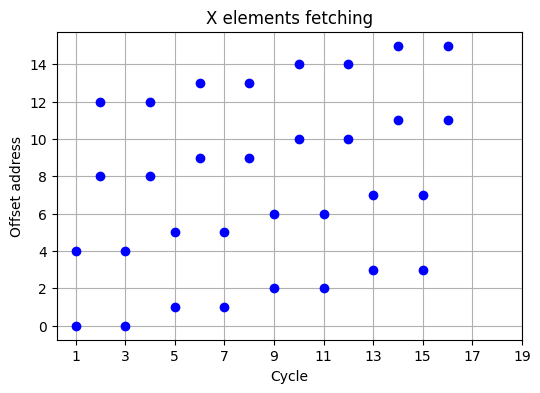

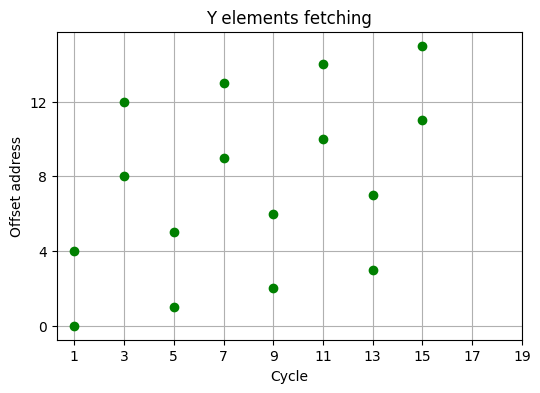

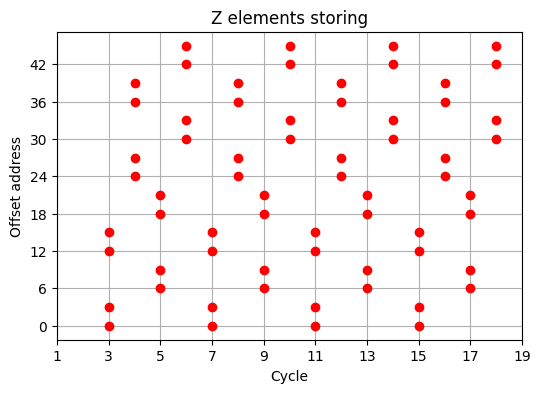

In [8]:
# region PRINTING AND DATA ITEMS PLOT

print("Reuse policy: Y\n")
print(f"Latency: {latency:.1f} cycles")
print(f"Average Input bandwidth: {Input_avg_bandwidth:.1f} Bytes/ cycle")
print(f"Peak Input bandwidth: {Input_peak_bandwidth:.1f} Bytes/ cycle")
print(f"Average Output bandwidth: {Output_avg_bandwidth:.1f} Bytes/ cycle")
print(f"Peak Output bandwidth: {Output_peak_bandwidth:.1f} Bytes/ cycle")
print(f"Average Combined bandwidth: {Combined_avg_bandwidth:.1f} Bytes/ cycle")
print(f"Peak Combined bandwidth: {Combined_peak_bandwidth:.1f} Bytes/ cycle")
print(f"X Reuse Distance (cycles): {X_reuse_distance:.1f}")
print(f"Y Reuse Distance (cycles): {Y_reuse_distance:.1f}")
print(f"Z Reuse Distance (cycles): {Z_reuse_distance:.1f}\n")

indices = [(X_offset_addr, 'Offset address', 'X elements fetching', 'blue', 'o', X_elem_size,
            X_elem_size * (In_data_size / 8)),
           (Y_offset_addr, 'Offset address', 'Y elements fetching', 'green', 'o', Y_elem_size,
            (Y_rows * (In_data_size / 8))),
           (Z_offset_addr_store, 'Offset address', 'Z elements storing', 'red', 'o', X_elem_size,
            X_elem_size * (Out_data_size / 8))]

for vals, y_label, label, color, marker, x_spacing, y_spacing in indices:
    plt.figure(figsize=(6, 4))

    # Calculate x values based on the number of cycles (use the range of indices for x-axis)
    x = np.arange(1, len(vals) + 2)  # x will range from 1 to the number of cycles in vals

    for i, cycle in enumerate(vals):
        plt.plot([i + 1] * len(cycle), cycle, color=color, marker=marker, linestyle='None')

    plt.xlabel('Cycle')
    plt.ylabel(y_label)
    plt.title(f'{label}')

    # Set tick positions with customized offset and spacing for x-axis
    plt.xticks(np.arange(min(x), max(x) + 1, x_spacing))

    # Set tick positions for y-axis with custom offset and spacing
    flattened_vals = [item for sublist in vals for item in sublist]
    plt.yticks(np.arange(int(min(flattened_vals)), int(max(flattened_vals)) + 1, y_spacing))

    plt.grid(True)
    plt.show()

# endregion

Finally we print the actual results of the computation

In [9]:
print("Matrix X:")
for row in X:
    print(row)

print("\nMatrix Y:")
for row in Y:
    print(row)

print("\nResult Z:")
for row in Z:
    print(row)

Matrix X:
['00000000', '01110010', '10001000', '11010010']
['10010101', '11111101', '01011010', '01000101']
['01000000', '10101011', '00101110', '10000101']
['01011011', '00001111', '10001000', '01010010']

Matrix Y:
['11010010', '11000011', '00100110', '01111011']
['00000000', '10001001', '01100101', '11011010']
['00100001', '00100000', '00101001', '00001000']
['10101111', '10101101', '10110101', '00100100']

Result Z:
['000000001010000100010110', '000000001101101111101100', '000000001101011100111100', '000000001000001011011100']
['000000001011010011111111', '000000010011001011000101', '000000001011100100100010', '000000010010101110001101']
['000000001001010101011001', '000000001110101111100100', '000000001011001001011110', '000000001100010010000010']
['000000001001010000111100', '000000001001010111000010', '000000000110001100101111', '000000000100100001000111']
